이 장에서 다루는 주제

1. 데이터 셋에서 누락된 값을 제거하거나 대체하기    (결측치 처리)
2. 머신 러닝 알고리즘을 위해 범주형 데이터 변환하기 (인코딩)
3. 모델과 관련이 높은 특성 선택하기                (feature selection)

# 1.누락된 데이터 다루기

## 1.1.테이블 데이터에서 누락된 값 식별하기

In [1]:
import pandas as pd
from io import StringIO

csv_data = "A,B,C,D\n1.0,2.0,3.0,4.0\n5.0,6.0,,8.0\n10.0,11.0,12.0,"
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [2]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

```text
TIP. 판단스와 넘파이

 사이킷런이 넘파이 배열을 다룰 수 있도록 개발되었지만 이따금 판다스의 DataFrame을 사용하여 데이터를 전처리하는 것이 편함
 사이킷런은 DataFrame보다 넘파이에 훨씬 익숙한 라이브러리이기 때문에, 사이킷런의 추정기에 주입하기 전에 df.values 속성으로 넘파이를 넣는 것이 바람직 함
```

## 1.2.누락된 값이 있는 훈련 샘플이나 특성을 제외

In [3]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [4]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [5]:
# 모든 열이 NaN일 때만 행 삭제
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [6]:
# NaN이 아닌 값이 네 개보다 작은 행을 삭제
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
# 특정 열에 NaN이 있는 행막 삭제
df.dropna(subset=["C"])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


## 1.3.누락된 값 대체 (interpolation)

In [8]:
from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_date = imr.transform(df.values)
imputed_date

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

1. `SimpleImputer`
    - `missing_values`: 결측값의 형태를 지정하는 파라미터
    - `strategy` : 채우고자 하는 값을 지정하는 파라미터 (mean, median, most_frequent, const)
        - 만약 strategy='const'라면, `finll_Value` 매개변수를 통해 채우려는 값을 지정함
    - 기본 동작 방식은 열에 대해 동작함
    - 행에 대한 동작을 원할 때는 다음과 같이 작성
        ```python
        from sklearn.preprocessing import FunctionTransformer
        ftr_imr = FunctionTransformer(lambda X: imr.fit_trainsform(X.T).T, validate=False)
        imputed_data = ftr.imr.fit_transform(df.values)
        ```
        <br>

2. `IterativeImputer`
    - 다른 특성을 사용하여 누락된 값을 예측함
    - 먼저 `initial_strategy` 매개변수에 지정된 방식으로 누락된 값을 초기화
    - 누락된 값이 있는 한 특성을 타깃으로 삼고 다른 특성을 사용해서 모델을 훈련하여 예측
    - 누락된 값이 있는 모든 특성을 순회
    - `initial_strategy` : mean, median, most_frequent, const 사용 가능
    ```text
        * 예측할 특성을 선택하는 순서
        ascending : 누락된 값이 가장 적은 특성 부터 선택
        descending : 누락된 값이 가장 큰 특성부터 선택
        roman : 왼쪽에서 오른쪽으로 선택
        arabic : 오른쪽에서 왼쪽으로 선택
        random : 랜덤하게 선택
    ```
    - 특성 예측은 종료 조건을 만족할 때까지 반복
        1. 각 반복 단계에서 이전 단계와 절댓값 차이 중 가장 큰 값 < 누락된 값을 제외하고 가장 큰 절댓값에 tol 매개변수를 곱한 것 (tol default: 1e-3)
        2. max_iter 매개변수에서 지정한 횟수에 도달할 때 종료 (default: 10)
    - 예측에 사용하는 모델은 estimator 매개변수에서 지정 (기본적으로 BayesianRidge 클래스 사용)
    - 예측에 사용할 특성 개수는 `n_nearest_fetures`에서 지정 가능
    - 상관 계수가 높은 특성을 우선하여 랜덤하게 선택 (default: None으로 모든 특성 사용)
    - IterativeImputer 클래스는 아직 실험적이기 때문에 사용하려면 먼저 `enable_iteraitve_imputer` 모듈을 임포트
        ```python
        from sklearn.experimental import enable_iterative_imputer
        from sklearn.impute import IterativeImputer
        iimr = IterativeImputer()
        iimr.fit_transform(df.values)
        ```
    <br>

3. `KNNImputer`
    - k-최근접 이웃 방법을 사용하여 누락된 값을 채움
    - 최근접 이웃의 개수는 `n_neighbors` 매개변수로 지정 (default: 5)
    - 샘플 개수가 `n_neighbors`보다 작으면 SimpleImputer(startegy='mean') 과 같은 결과를 얻음
        ```python
        from sklearn.impute import KNNImputer
        kimr = KNNImputer()
        kimr.fit_transform(df.values)
        ```

# 2.범주형 데이터 다루기

## 2.1.판다스를 사용한 범주형 데이터 인코딩

In [9]:
import pandas as pd
df = pd.DataFrame([
    ['green','M',10.1,'class2'],
    ['red','L',13.5,'class1'],
    ['blue','XL',15.3,'class2']
])
df.columns = ['color','size','price','classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


## 2.2.순서가 있는 특성 매핑
- 산술적 차이가 있을 때!

In [10]:
size_mapping = {'XL':3, 'L':2, 'M':1}
df['size']=df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


## 2.3.클래스 레이블 인코딩

- 사이킷런의 분류 추정기 대부분은 자체적으로 클래스 레이블을 정수로 변환해 줌
- 사소한 실수를 방지하기 위해 클래스 레이블을 정수 배열로 전달하는 것이 좋은 습관
- 클래스 레이블은 순서가 있지 않음

In [11]:
import numpy as np
class_mapping={label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [12]:
# df["classlabel"] = df["classlabel"].map(class_mapping)
df["classlabel"].map(class_mapping)


0    1
1    0
2    1
Name: classlabel, dtype: int64

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df["classlabel"].values)
y

array([1, 0, 1])

## 2.4.순서가 없는 특성에 원-핫 인코딩 적용

- 사이킷런의 분류용 추정기는 클래스 레이블을 순서가 없는 범주형 데이터로 다룸
- 따라서 LabelEncoder를 사용하여 간편하게 문자열 레이블을 정수로 인코딩

In [14]:
X = df[['color','size','price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

- LabelEncoder는 타깃 레이블을 인코딩하기 위한 클래스이므로 입력 데이터로 1차원 배열을 기대함
- 그렇기 때문에 color만 추출해서 라벨 인코딩을 수행
- 데이터 셋에 변경해야 할 열이 많다면 동일한 작업을 반복해야 함
- 범주형 데이터를 정수로 인코딩하는 `OrdicnalEncoder`와 판다스 데이터 프레임의 열마다 다른 변환을 적용하도록 도와주는 `ColumnTransformer`를 이용하면 여러 개의 열을 한 번에 변환 가능
```python
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OrdinalEncoder
    ord_enc = OrdinalEncoder(dtype=int)
    col_trans = ColumnTransformer([('ord_enc', ord_enc, ['color'])])
    X_trans = col_trans.fit_transform(df)
    X_trans
```
- `ColumnTransformer`
    - 첫 번째 매개변수로 트랜스포머의 리스트를 받음
    - 트랜스포머는 이름, 변환기, 변환할 열의 리스트로 이루어진 튜플
    - 이름은 'ord_enc', 변환기는 `OrdinalEncoder` 객체, 변환 열은 'color' 열
    - 변환기는 `named_transformers_` 속성에서 앞서 지정한 `ord_enc` 이름으로 참조 가능
    - 정수로 인코딩된 값을 다시 문자열로 변환하려면 아래를 참조
        ```python
            col_trans.named_transformers_['ord_enc'].inverse_transform(X_trans)
        ```
- `OrdinalEncdoer`
    - `dtype` : 매개변수 기본값은 `np.float64`로 실수 인코딩
    - `categories` : 훈련 데이터셋에서 자동으로 범주를 인식 (default: auto)
    - `categories`의 경우 매개변수에 직접 범주 리스트를 전달할 수 있음 (인식된 범주는 `categories_` 속성에 저장)
    - `handle_unknown` : 알 수 없는 범주 데이터가 `transform()`메서드로 전달될 때 에러가 발생 (default: error)
    - `unknown_value` : `handle_unknown='use_encoded_value'`로 설정하면 알 수 없는 범주를 `unknown_value`에 지정한 정수값으로 설정

In [15]:
from sklearn.preprocessing import OneHotEncoder as OHE
X = df[['color', 'size', 'price']].values
color_ohe = OHE()
color_ohe.fit_transform(X[:, 0].reshape(-1,1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

- 배열의 다른 두 열을 수정하지 않기 위해 `OneHotEncoder`를 하나의 열(`X[:,0].reshape(-1,1)`)에만 적용
- 여러 개의 특성이 있는 배열에서 특정 열만 변환 하려면 `ColumnTransformer`를 사용

In [16]:
from sklearn.compose import ColumnTransformer as CT
X = df[['color','size','price']].values
c_transf = CT([
    ('onehot', OHE(),[0]),
    ('nothing', 'passthrough', [1,2])
])
c_transf.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

- 원-핫 인코딩된 데이터셋을 사용할 때 다중 공선성(multicollinearity) 문제를 유념해야 함
- 어떤 알고리즘에는 이슈가 될 수 있음 (역행렬을 구하는 연산이 포함된 알고리즘)
- 특성 간의 상관관계가 높으면 역행렬을 계산하기 어려워 수치적으로 불안정해짐
- 변수 간의 상관관계를 감소하려면 원-핫 인코딩된 배열에서 특성 열 하나를 삭제
- 이렇게 특성을 삭제해도 잃는 정보는 없음
- `pd.get_dummies()`함수에서 `drop_first=True`로 설정해주면 됨
- `OneHotEncoder`에서는 `categories='auto', drop='first'`로 설정해주면 됨

# 3.데이터셋을 훈련 데이터 셋과 테스트 데이터셋으로 나누기

- 모델 실전 투입 전, 테스트 데이터셋에 있는 레이블과 예측을 비교
- 이는 편향되지 않은 성능을 측정하기 위해서임

In [17]:
# df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine = pd.read_csv('./datasets/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity',
                   'Hue', 'OD280/OD315 of diluted wineds', 'Proline']
print('클래스 레이블', np.unique(df_wine['Class label']))

클래스 레이블 [1 2 3]


In [18]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wineds,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [19]:
from sklearn.model_selection import train_test_split

X = df_wine.drop(axis=1, columns=['Class label']).values
y = df_wine['Class label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0, stratify=y)

- `test_size` : 테스트 셋의 비율
- `stratify` : y를 전달하면 훈련 데이터셋과 테스트 데이터셋에 있는 클래스 비율이 원본 데이터셋과 동일하게 유지됨
- [머신러닝의 모델 평가와 모델 선택, 알고리즘 선택](https://arxiv.org/pdf/1811.12808.pdf)를 참고하면, Train/Test의 비율을 적절히 조절할 수 있음
- 또한 테스트 셋까지 통합하여 다시 한 번 학습시키는 과정을 통해 예측 성능을 향상 시킬 수 있음
- 그러나 소규모 데이터 셋에서는 일반화를 어렵게 만들 수도 있게 됨

# 4.특성 스케일 맞추기

- 결정트리, 랜덤 포레스트와 같은 모델은 특성 스케일 조정에 대해 걱정할 필요가 없는 알고리즘
- KNN의 경우 유클리디안 거리 지표를 사용할 때, 스케일이 동일하지 않으면 오차가 발생할 수 있음
- 대표적인 스케일 특성을 맞추는 방법은 <span style="color:gold">정규화</span>와 <span style="color:gold">표준화</span>가 있음
- 대부분 정규화는 특성 스케일을 0~1범위로 맞추는 것(최소-최대 스케일 변환)

1. `MinMaxScaler`
    - 최소-최대 스케일 변환 정규화는 정해진 범위의 값이 필요할 때 유용하게 사용할 수 있는 기법
        ```python
            from sklearn.preprocessing import MinMaxScaler
            mms = MinMaxScaler()
            X_train_norm = mms.fit_transform(X_train)
            X_test_norm = mms.transform(X_test)
        ```
        <br>
2. `StandardScaler`
    - 표준화는 특성 평균을 0에 맞추고 표준 편차를 1로 만드는 정규 분포로 표준화함 (이상치에 덜 민감)
        ```python
            from sklearn.preprocessing import StandardScaler
            sds = StandardScaler()
            X_train_std = sds.fit_transform(X_train)
            X_test_std = sds.transform(X_test)
        ```
        <br>
3. `RobustScaler`
    - 이상치가 많이 포함된 작은 데이터셋을 다룰 때 도움이 됨
    - 데이터셋에 적용된 머신 러닝 알고리즘이 과대적합되기 쉽다면 `RobustScaler`가 좋은 선택지
    - 특성 열마다 독립적으로 작용하며 중간 값을 뺀 다음 데이터 셋의 Q1, Q3를 사용해서 데이터셋의 스케일을 조절
        ```python
            from sklearn.preprocessing import RobustScaler
            rbs = RobustScaler()
            X_train_robust = rbs.fit_transform(X_train)
            X_test_robust = rbs.transform(X_test)
        ```
    - Robust Scaling의 수식은 아래와 같음
        $$
        x_{robust}^{(i)}=\frac{x^{(i)}-q_2}{q_3-q_1}
        $$
        <br>
4. `MaxAbsScaler`
    - 각 특성 별로 데이터를 최대 절댓값으로 나눔
    - 각 특성의 최대값은 1이되고, 전체 특성은 -1~1
        ```python
            from sklearn.preprocessing import MaxAbsScaler
            mas = MaxAbsScaler()
            X_train_maxabs = mas.fit_transform(X_train)
            X_test_maxabs = mas.transform(X_test)
        ```

# 5.유용한 특성 선택

- 과대적합의 이유는 주어진 훈련 데이터에 비해 모델이 너무 복잡하기 때문
- 일반화 오차를 감소시키기 위해 많이 사용하는 방법은 다음과 같음
    1. 더 많은 훈련 데이터 수집
    2. 규제를 통해 복잡도 제한
    3. 파라미터 개수가 적은 간단한 모델을 선택
    4. 데이터 차원 줄이기

## 5.1.모델 복잡도 제한을 위한 L1 규제와 L2 규제
- L2 규제와 L1 규제는 다음과 같음
    $$\begin{align*}
        L2: &\begin{Vmatrix}\mathbf{w}\end{Vmatrix}_{2}^{2} = \sum_{j=1}^{m}w_{j}^{2} \\
        L1: &\begin{Vmatrix}\mathbf{w}\end{Vmatrix}_{1} = \sum_{j=1}^{m}\begin{vmatrix}w_{j}\end{vmatrix}
    \end{align*}$$
- L1 규제는 L2 규제와 대조적으로 보통 희소한 특성 벡터를 만듦 (대부분의 특성 가중치가 0이 됨)
- 실제로 관련 없는 특성이 많은 고차원 데이터셋일 경우 이런 희소성이 도움 될 수 있음
- 특히 훈련 샘플보다 관련 없는 특성이 더 많은 경우

## 5.2.L2 규제의 기하학적 해석

- L2 규제는 비용 함수에 페널티 항을 추가 함
- 규제가 없는 비용 함수로 훈련한 모델에 비해 가중치 값을 아주 작게 만드는 효과를 냄
- 규제를 더 작은 가중치를 얻기 위해 비용 함수에 추가하는 페널티 항으로 생각할 수 있음
- 다른 말로, 큰 가중치를 제한함
- 규제 파라미터 $\lambda$로 규제 강도를 크게 하면 가중치가 0에 가까워지고, 훈련 데이터에 대한 모델 의존성을 줄일 수 있음
- 목표는 규제가 없는 비용과 페널티 항의 합을 최소화 하는 것
- 모델을 학습할 만한 충분한 훈련 데이터가 없을 때 편향을 추가하여 모델을 간단하게 만ㄷ름으로써 분산을 줄이는 것으로 해석 가능

## 5.3.L1 규제를 사용한 희소성

- 비용 함수의 등고선이 L1 다이아몬드와 만남
- L1 규제의 등고선은 날카롭기에 비용 함수의 포물선과 L1 다이아몬드의 경계가 만나는 최적 점은 축에 가깝게 위치할 가능성이 높음
- 위와 같은 이유가 희소성이 나타나는 이유

In [20]:
from sklearn.linear_model import LogisticRegression as LGR
LGR(solver='liblinear', penalty='l1')

LogisticRegression(penalty='l1', solver='liblinear')

- `penalty`: 규제 종류 파라미터
- `solver` : lbfgs, newton-cg, sag, saga, liblinear 가 존재 (lbfgs, newton-cg, sag는 l2 규제만 지원)
- lbfgs는 l1 규제를 지원하지 않기에 다른 알고리즘 선택 (liblinear)

In [21]:
from sklearn.preprocessing import StandardScaler
sds = StandardScaler()
X_train_std = sds.fit_transform(X_train)
X_test_std = sds.transform(X_test)

lr = LGR(solver='liblinear', penalty='l1', C=1.0, random_state=1)
lr.fit(X_train_std, y_train)
print('훈련 정확도:', lr.score(X_train_std, y_train))
print('테스트 정확도:', lr.score(X_test_std, y_test))

훈련 정확도: 1.0
테스트 정확도: 1.0


In [22]:
# w_0
lr.intercept_

array([-1.26392152, -1.21596534, -2.37040177])

- `solver='liblinear'`로 초기화한 LGR 객체를 다중 클래스 데이터셋에 적용하면 OvR 방식 사용
- 첫 번째 절편은 클래스 1을 클래스 2/3과 구분하는 모델에 속한 것
- 두 번째 클래스 2를 클래스 1/3과 구분하는 모델의 절편
- 세 번째는 클래스 3을 클래스 1/2와 구분하는 모델의 절편

In [23]:
# w_j (j>0)
lr.coef_

array([[ 1.24567209,  0.18072301,  0.74682115, -1.16438451,  0.        ,
         0.        ,  1.1595535 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55864751,  2.50891241],
       [-1.53644846, -0.38769843, -0.99485417,  0.36489012, -0.05989298,
         0.        ,  0.66853184,  0.        ,  0.        , -1.93460212,
         1.23246414,  0.        , -2.23212696],
       [ 0.1355558 ,  0.16880291,  0.35718019,  0.        ,  0.        ,
         0.        , -2.43768478,  0.        ,  0.        ,  1.5635432 ,
        -0.81834553, -0.4930494 ,  0.        ]])

- `lr.coef_` 속성에 있는 가중치는 클래스마다 벡터 하나씩 세 개의 행이 있는 가중치 배열
- 각 행은 13개의 가중치를 가짐
- 각 가중치와 13차원의 Wine 데이터셋의 특성을 곱해 최종 입력 계산

- L1 규제는 결과적으로 데이터셋에 관련이 적은 특성이 있더라도 견고한 모델을 만들어 줌
- 엄밀히 말하면 가중치 벡터는 0이 아닌 원소가 더 많기 때문에 꼭 희소하지는 않음
- 규제 강도를 높여 희소성을 강화할 수 있음 (매개변수 C값을 낮춤)

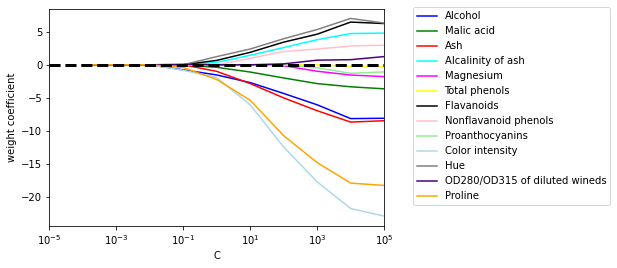

In [24]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue', 'gray', 'indigo', 'orange']
weights, params = [], []
for c in np.arange(-4., 6):
    lr = LGR(solver='liblinear', penalty='l1', C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=df_wine.columns[column+1], color=color)
    
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
plt.show()

# 5.4.순차 특성 선택 알고리즘

- 과대 적합을 피하는 다른 방법은 특성 선택을 통한 차원 축소
- <span style="color:gold">특성 선택</span>과 <span style="color:gold">특성 추출</span> 두 가지 방법이 있음
- 특성 선택 : 원본 특성에서 일부를 선택
- 특성 추출 : 일련의 특성에서 얻은 정보로 새로운 특성을 만듦
- 순차 특성 선택 알고리즘 : 탐욕적 탐색 알고리즘으로 초기 d차원의 특성공간을 k<d인 k 차원의 특성 부분 공간으로 축소
- 특성 선택 알고리즘은 주어진 문제에 가장 관련이 높은 특성 부분 집합을 자동으로 선택하는 것이 목적
- 관계없는 특성이나 잡음을 제거하여 계산 효율성을 높이고 모델의 일반화 오차를 줄임
- 규제를 제공하지 않는 알고리즘 사용 시 유용
- 전통적인 방법은 순차 후진 선택 (계산 효율을 향상하기 위해 모델 성능을 적게 희생하면서 초기 특성의 부분 공간으로 차원 축소)

**순차 후진 선택 알고리즘의 아이디어**

- SBS는 새로운 특성의 부분 공간이 목표하는 특성 개수가 될 때까지 전체 특성에서 순차적으로 특성을 제거
- 각 단계에서 어떤 특성을 제거할지 판단하기 위해 최대화할 기준 함수 정의
- 기준 함수에서 계산한 값은 어떤 특성을 제거하기 전후의 모델 성능 차이
- 각 단계에서 제거할 특성은 기준 값이 가장 큰 특성으로 정의
- 각 단계에서 제거했을 때 성능 손실이 최소가 되는 특성 제거

**SBS 알고리즘의 4단계**

1. 알고리즘 $k=d$로 초기화. $d$는 전체 특성공간 $X_d$의 차원
2. 조건 $\mathbf{x}^- = \mathsf{argmax}J(\mathbf{X}_k-\mathbf{x})$를 최대화하는 특성 $\mathbf{x}^-$를 결정 ($\mathbf{x}\in\mathbf{X}_k$)
3. 특성 집합에서 특성 $\mathbf{x}^-$를 제거. 즉, $\mathbf{X}_{k-1}:=\mathbf{X}_k-\mathbf{x}^-;k:=k-1$
4. $k$가 목표하는 특성 개수가 되면 종료. (아니면 단계 2로 돌아감)

In [25]:
from sklearn.base import clone
from itertools import combinations as comb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

class SBS():
    def __init__(self, estimator, k_fetures, scoring=accuracy_score, test_size=.25, random_state=1):
        self.scoring = scoring
        self.estimator = estimator
        self.k_features = k_fetures
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores, subsets = [], []
            
            for p in comb(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim-=1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

- `k_features` : 목표 특성 개수 지정
- `fit()`
    - while 루프 안에서 `itertools.combinations` 함수에 의해 생성된 특성 조합을 평가하고 원하는 차원이 남을 때까지 특성을 줄임
    - 각 반복에서 내부적으로 만든 `X_test` 테스트 데이터셋에 기초한 최적 조합의 정확도 점수를 `self.scores_`리스트에 모음
    - 이 점수를 사용하여 나중에 결과를 평가
    - 최종 선택된 특성의 열 인덱스는 `self.indices_`에 할당
-`transform()` : 선택된 특성 열로 구성된 새로운 데이터 배열을 반환할 때 사용

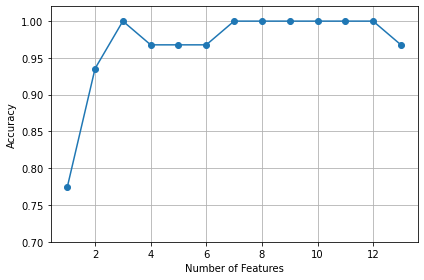

In [26]:
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as KNN

knn = KNN(n_neighbors=5)

sbs = SBS(knn, k_fetures=1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

In [27]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wineds'], dtype='object')


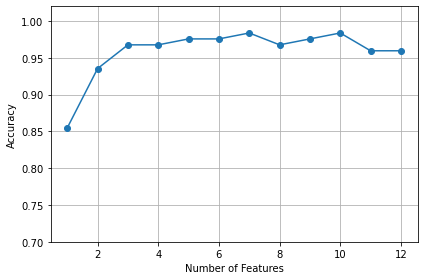

In [28]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS

scores = []
for n_features in range(1,13):
    sfs = SFS(knn, n_features_to_select=n_features, n_jobs=-1)
    sfs.fit(X_train_std, y_train)
    f_mask = sfs.support_
    knn.fit(X_train_std[:, f_mask], y_train)
    scores.append(knn.score(X_train_std[:, f_mask], y_train))
    
plt.plot(range(1,13), scores, marker='o')
plt.ylim([.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of Features')
plt.grid()
plt.tight_layout()
plt.show()    

In [29]:
sfs = SFS(knn, n_features_to_select=7, n_jobs=-1)
sfs.fit(X_train_std, y_train)
print(sfs.n_features_to_select_)
f_mask = sfs.support_
df_wine.columns[1:][f_mask]

7


Index(['Alcohol', 'Ash', 'Magnesium', 'Flavanoids', 'Color intensity', 'Hue',
       'Proline'],
      dtype='object')

# 6.랜덤 포레스트의 특성 중요도 사용

- 로지스틱 회귀 : L1 규제를 사용하여 관련이 적은 특성의 가중치를 0으로 만듦
- KNN : SBS 알고리즘을 사용하여 특성을 선택
- 랜덤 포레스트 : 특성 중요도 활용
    - `RandomForestClassifier` 모델 훈련 후 `feature_importances_`를 확인할 수 있음

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wineds  0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


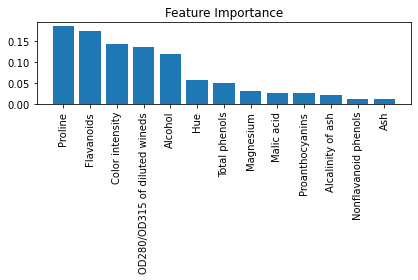

In [30]:
from sklearn.ensemble import RandomForestClassifier as RFC

feat_labels = df_wine.columns[1:]
forest = RFC(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]     #[::-1] reverse

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [31]:
from sklearn.feature_selection import SelectFromModel as SFM

sfm = SFM(forest, threshold=.1, prefit=True)
X_selected = sfm.transform(X_train)
print('임계 조건을 만족하는 샘플 수: ', X_selected.shape[1])

for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

임계 조건을 만족하는 샘플 수:  5
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wineds  0.136162
 5) Alcohol                        0.118529
